# Quantum Connection Setup

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

from src.directComm import *

# Analysis Functions

In [3]:
import re
from pathlib import Path
def get_img_path(label:str):
    # resolve output directory relative to this file (avoid changing cwd)
    base = Path.cwd().resolve()  # repo root
    subfolder = re.sub(r'\s+', '_', label.splitlines()[0])
    outdir = base / "img" / subfolder
    label = label.split(maxsplit=2)[0] + "_" + label.splitlines()[1]
    outdir.mkdir(parents=True, exist_ok=True)
    label = re.sub(r'\s+', '_', str(label)).strip()          # collapse whitespace/newlines
    label = re.sub(r'[^A-Za-z0-9._-]', '_', label)           # keep a safe subset of chars
    label = re.sub(r'[()]', '', label)
    label = label[:190] + ".png"
    imgpath = outdir / label
    return imgpath 

In [4]:
def unique_and_probs(data):
    count_times = [(v, data.count(v)) for v in set(data)]
    sorted_times = sorted(count_times)
    
    unique_sorted = [v[0] for v in sorted_times] 
    counts_sorted = [v[1] for v in sorted_times]
    # normalize counts to probabilities
    total = sum(counts_sorted)
    probs = [c / total for c in counts_sorted] if total > 0 else counts_sorted

    return unique_sorted, probs

In [5]:
def sim_duration_stats(sim_end_times):
    # median simulation end time, that still has the delay in it from the sender
    simulation_end_times = sim_end_times.copy()
    simulation_end_times.sort()
    median_simulation_end_time = simulation_end_times[len(simulation_end_times) // 2]

    print("Simulation Time Statistics:")
    print(f"Median: {median_simulation_end_time} μs")
    print(f"Mean: {sum(simulation_end_times)/len(simulation_end_times):.4f}")
    print(f"Min: {min(simulation_end_times):.4f}")
    print(f"Max: {max(simulation_end_times):.4f}")

In [6]:
def qubits_stats(total_qubits_sent):
    # median qubits sent until reception
    qubits_sent = total_qubits_sent.copy()
    qubits_sent.sort()
    median_qubits_sent = qubits_sent[len(qubits_sent) // 2]

    print("Qubits Sent Statistics:")
    print(f"Median: {median_qubits_sent}")
    print(f"Mean: {sum(qubits_sent)/len(qubits_sent):.4f}")
    print(f"Min: {min(qubits_sent):.4f}")
    print(f"Max: {max(qubits_sent):.4f}")

In [7]:
def arrival_times_stats(arrival_times):
    # median arrival time
    arrival_times_temp = arrival_times.copy()
    arrival_times_temp.sort()
    median_arrival_time = arrival_times_temp[len(arrival_times_temp) // 2]

    print("Arrival Time Statistics:")
    print(f"Median: {median_arrival_time} μs")
    print(f"Mean: {sum(arrival_times_temp)/len(arrival_times_temp):.4f}")
    print(f"Min: {min(arrival_times_temp):.4f}")
    print(f"Max: {max(arrival_times_temp):.4f}")

In [8]:
def fidelity_stats(fidelities):
    # median fidelity
    fidelities_temp = fidelities.copy()
    fidelities_temp.sort()
    median_fidelity = fidelities_temp[len(fidelities_temp) // 2]

    print("Fidelity Statistics:")
    print(f"Median: {median_fidelity:.4f}")
    print(f"Mean: {sum(fidelities_temp)/len(fidelities_temp):.4f}")
    print(f"Min: {min(fidelities_temp):.4f}")
    print(f"Max: {max(fidelities_temp):.4f}")

In [38]:

def plot_fidelity_distribution(arrival_times:dict, fidelities:dict, title, expected=None):
    plt.figure(figsize=(10, 6))
    if expected is None: expected = {}
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for idx, (name, data) in enumerate(fidelities.items()):
        color = colors[idx % len(colors)]

        timed_fidelities = zip(arrival_times[name], data)
        sort = sorted(set(timed_fidelities), key=lambda f: f[0])
        unique_times = [t[0] for t in sort]
        unique_fids = [t[1] for t in sort]
        plt.plot(unique_times, unique_fids, label=name,
                 linewidth=2, marker='o', color=color)
        if name not in expected.keys():
            expected[name] = np.mean(data)
            print(f"{name} mean = {expected[name]}")
        plt.axhline(expected[name], linestyle='--', label=f"{name} - analytical", color=color)
        
    plt.xlabel("Number of attempts", fontsize=12)
    plt.ylabel("Fidelity", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(get_img_path(title), dpi=300)
    plt.show()
    plt.close()


In [10]:
def plot_pmf_cdf_arrival_times_with_analytic(arrival_times: dict,
                                             title: str,
                                             p_ge_dict: dict | None = None,
                                             max_distances: int | None = None):
    
    fig, (ax_pmf, ax_cdf) = plt.subplots(1, 2, figsize=(12, 5))
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    for idx, (name, data) in enumerate(arrival_times.items()):
        if max_distances is not None and idx >= max_distances:
            break

        unique_sorted, probs = unique_and_probs(data)
        x = np.asarray(unique_sorted, dtype=float)
        y = np.asarray(probs, dtype=float)
        color = colors[idx % len(colors)]

        ax_pmf.plot(
            x, y, marker="o", markersize=2, linestyle="-", linewidth=0.9,
            color=color, label=name
        )
        cdf_sim = np.cumsum(y)
        ax_cdf.plot(
            x, cdf_sim, marker="o", markersize=2, linestyle="-", linewidth=0.9,
            color=color
        )

        if p_ge_dict is not None and name in p_ge_dict:
            p_ge = p_ge_dict[name]
        else:
            mean_attempts = np.mean(data)
            if mean_attempts <= 0:
                continue
            p_ge = 1.0 / mean_attempts

        t_vals = np.arange(1, int(x.max()) + 1)
        pmf_analytic = p_ge * (1 - p_ge) ** (t_vals - 1)
        cdf_analytic = 1 - (1 - p_ge) ** t_vals

        ax_pmf.plot(
            t_vals, pmf_analytic,
            linestyle="--", linewidth=0.8, color=color
        )
        ax_cdf.plot(
            t_vals, cdf_analytic,
            linestyle="--", linewidth=0.8, color=color
        )

    for ax in (ax_pmf, ax_cdf):
        ax.set_xscale("log")
        ax.grid(True, alpha=0.25, which="both")
        ax.tick_params(axis="both", labelsize=9)

    ax_pmf.set_xlabel("# attempts", fontsize=11)
    ax_pmf.set_ylabel("Probability", fontsize=11)
    ax_pmf.set_title("PMF", fontsize=12, pad=6)

    ax_cdf.set_xlabel("# attempts", fontsize=11)
    ax_cdf.set_ylabel("Probability", fontsize=11)
    ax_cdf.set_title("CDF", fontsize=12, pad=6)

    ax_pmf.legend(
        title="distance", fontsize=9, title_fontsize=9,
        loc="upper right", frameon=False
    )

    sim_handle = Line2D([0], [0], color="black", linestyle="-", marker="o",
                        markersize=2, linewidth=0.9, label="simulation")
    ana_handle = Line2D([0], [0], color="black", linestyle="--",
                        linewidth=0.8, label="analytic")
    fig.legend(
        handles=[sim_handle, ana_handle],
        loc="lower center", ncol=2, fontsize=9, frameon=False,
        bbox_to_anchor=(0.5, 0.03)
    )
    fig.suptitle(title, fontsize=14, y=0.97)
    fig.tight_layout(rect=(0.03, 0.08, 1.0, 0.9))

    plt.savefig(get_img_path(title), dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


# Run Simulation

In [12]:
from src.scenarios import *
all_results = {}

for i, params in enumerate(param_sets):
    label = label_full(params)
    all_results[label] = []
    results = []
    for dist in params["distances"]:
        print(f"Running set {i+1}/{len(param_sets)}: {dist}km - {label}")

        results.append(setup_sim(
            shots=params["shots"],
            distance=dist,
            p_loss_init=params["p_loss_init"],
            p_loss_length=params["p_loss_length"],
            t1=params["t1"],
            t2=params["t2"],
        ))

    all_results[label] = {}
    for d in params["distances"]:
        all_results[label] = {
            "label_loss": label_loss(params),
            "label_noise": label_noise(params),
            "sim_end_times": {},
            "total_qubits_sent": {},
            "arrival_times": {},
            "fidelities": {},
        }
    for d, run in zip(params["distances"], results):
        all_results[label]["sim_end_times"][f"{d}km"] = [res[0] for res in run]
        all_results[label]["total_qubits_sent"][f"{d}km"] = [res[1] for res in run]
        all_results[label]["arrival_times"][f"{d}km"] = [res[2] for res in run]
        all_results[label]["fidelities"][f"{d}km"] = [res[3] for res in run]
        
print("All simulations completed!")

Running set 1/7: 5km - Ideal case (0.0 init, 0.0dB/km, T1=0.0us, T2=0.0us)
Running set 1/7: 20km - Ideal case (0.0 init, 0.0dB/km, T1=0.0us, T2=0.0us)
Running set 1/7: 50km - Ideal case (0.0 init, 0.0dB/km, T1=0.0us, T2=0.0us)
Running set 2/7: 5km - High initial loss fibre (0.9 init, 0.02dB/km, T1=0.0us, T2=0.0us)
Running set 2/7: 20km - High initial loss fibre (0.9 init, 0.02dB/km, T1=0.0us, T2=0.0us)
Running set 2/7: 50km - High initial loss fibre (0.9 init, 0.02dB/km, T1=0.0us, T2=0.0us)
Running set 3/7: 5km - Zero length loss fibre (0.5 init, 0.0dB/km, T1=0.0us, T2=0.0us)
Running set 3/7: 20km - Zero length loss fibre (0.5 init, 0.0dB/km, T1=0.0us, T2=0.0us)
Running set 3/7: 50km - Zero length loss fibre (0.5 init, 0.0dB/km, T1=0.0us, T2=0.0us)
Running set 4/7: 5km - High length loss fibre (0.0 init, 0.5dB/km, T1=0.0us, T2=0.0us)
Running set 4/7: 20km - High length loss fibre (0.0 init, 0.5dB/km, T1=0.0us, T2=0.0us)
Running set 4/7: 50km - High length loss fibre (0.0 init, 0.5dB/km


=== Ideal case (0.0 init, 0.0dB/km, T1=0.0us, T2=0.0us) ===
5km mean = 0.9999999999999998
20km mean = 0.9999999999999998
50km mean = 0.9999999999999998


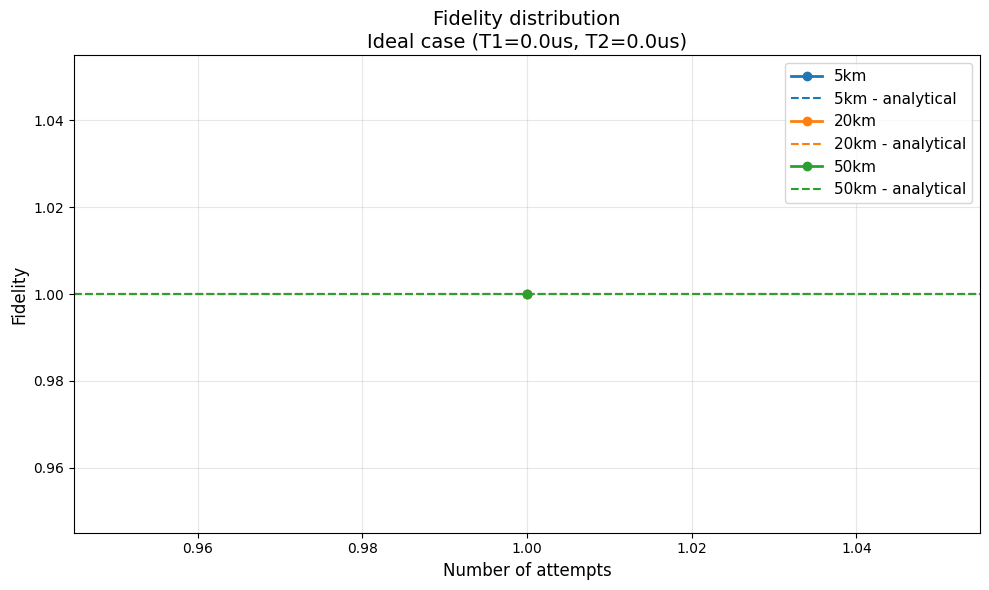


=== High initial loss fibre (0.9 init, 0.02dB/km, T1=0.0us, T2=0.0us) ===
5km mean = 0.9999999999999999
20km mean = 0.9999999999999999
50km mean = 0.9999999999999999


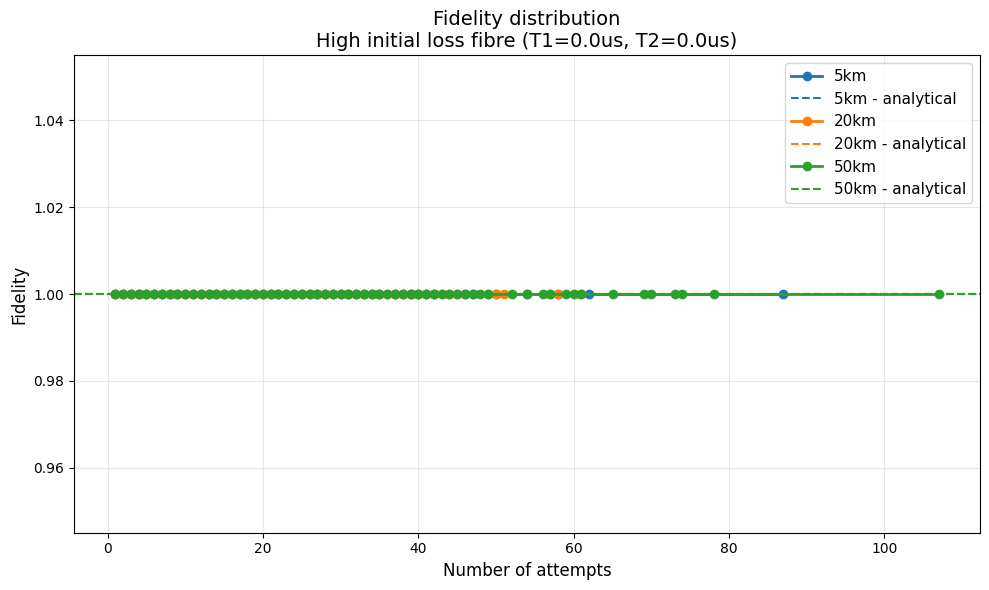


=== Zero length loss fibre (0.5 init, 0.0dB/km, T1=0.0us, T2=0.0us) ===
5km mean = 0.9999999999999999
20km mean = 0.9999999999999999
50km mean = 0.9999999999999999


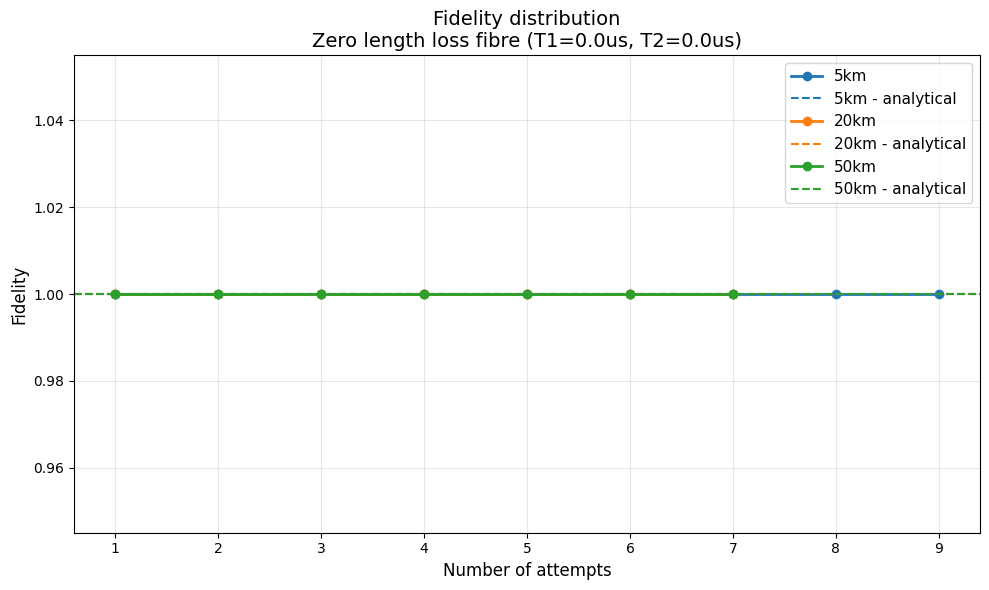


=== High length loss fibre (0.0 init, 0.5dB/km, T1=0.0us, T2=0.0us) ===
5km mean = 0.9999999999999999
20km mean = 0.9999999999999999
50km mean = 0.9999999999999999


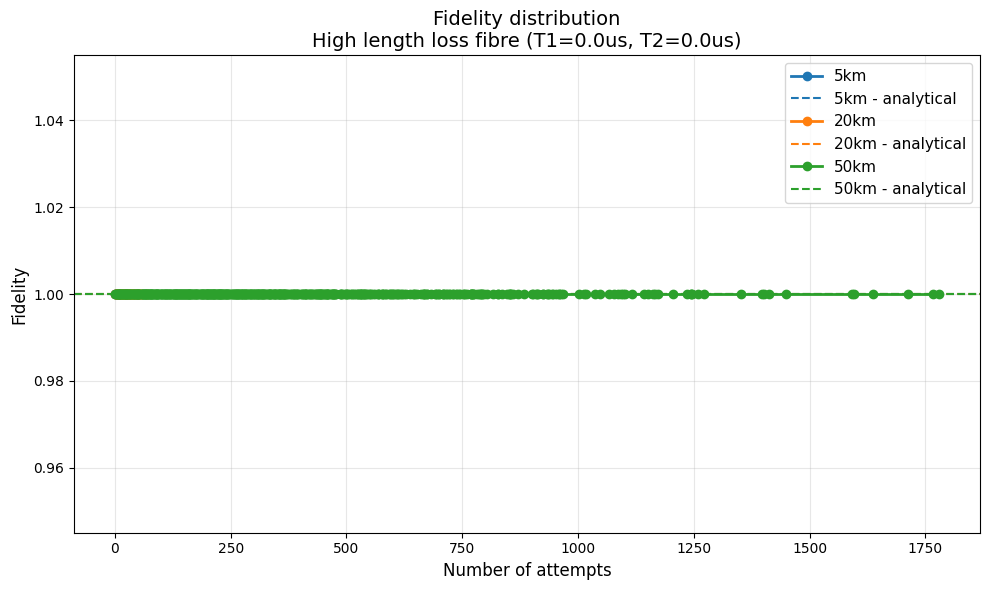


=== Low-Noise fibre (t1 = 500km travel time) (0.0 init, 0.2dB/km, T1=2500.0us, T2=250.0us) ===
5km mean = 0.974644123490862
20km mean = 0.9084918176879193
50km mean = 0.8124955846616708


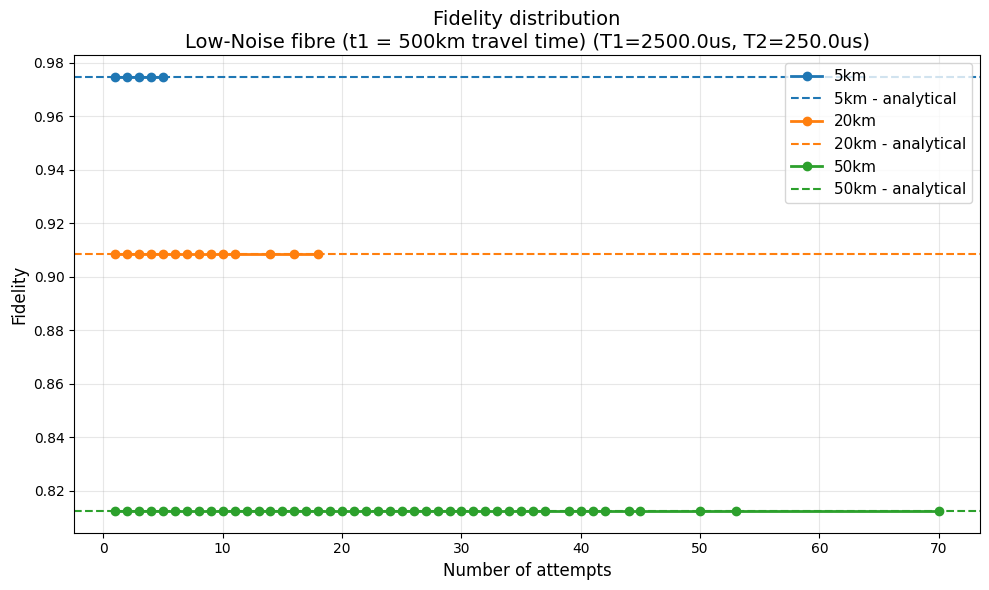


=== High-Noise fibre (t1 = 50km travel time) (0.0 init, 0.2dB/km, T1=250.0us, T2=25.0us) ===
5km mean = 0.8124955846616708
20km mean = 0.6532517362803384
50km mean = 0.5848012998085262


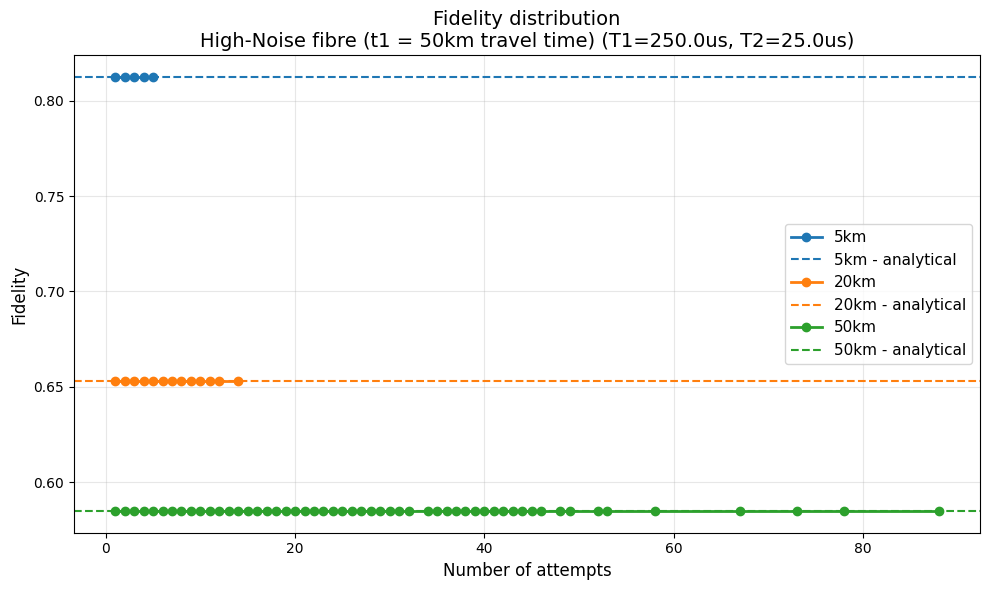


=== Extreme-Noise fibre (t1 = 5km travel time) (0.0 init, 0.1dB/km, T1=25.0us, T2=2.5us) ===
5km mean = 0.5848012998085262
20km mean = 0.5045581331444212
50km mean = 0.5000113498536214


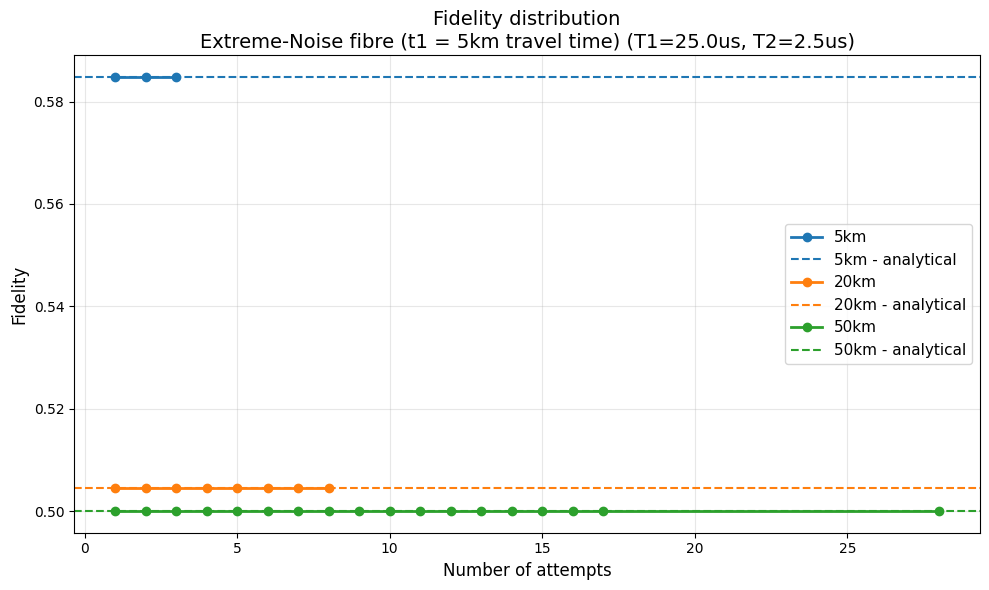

In [39]:
for label, data in all_results.items():
    print(f"\n=== {label} ===")
    sim_end_times = data["sim_end_times"]
    total_qubits_sent = data["total_qubits_sent"]
    arrival_times = data["arrival_times"]
    fidelities = data["fidelities"]


    # Plots: PMF & CDF in the same figure + analytical solution
    # plot_pmf_cdf_arrival_times_with_analytic(
    #     total_qubits_sent,
    #     title=f"PMF_CDF of arrival times\n{data["label_loss"]}",
    # )

    plot_fidelity_distribution(
        total_qubits_sent, fidelities, 
        title=f"Fidelity distribution\n{data["label_noise"]}"
    )